In [1]:
import pandas as pd
from pathlib import Path

In [2]:
def extract_information(file_path):
    """
    Extracts the implementation type (CPU or GPU), the argument value from the filename,
    and the execution time from the content of the file.
    """
    # Extract implementation and number of docs from filename
    parts = file_path.stem.split('-')  # split the stem part of the filename
    implementation = parts[1].upper()  # Get 'GPU' or 'CPU' and make it uppercase
    iteration = int(parts[-2])
    n_docs = int(parts[-1])  # Convert the number of documents part to integer
    
    # Read execution time from file
    with file_path.open('r') as file:
        for line in file:
            if "Elapsed time:" in line:
                execution_time = float(line.split()[-2])  # Get the last second to last part assuming "Elapsed time: X ms"
                break
    
    return dict(implementation=implementation, n_docs=n_docs, execution_time=execution_time, iteration=iteration)

In [3]:
# Collect all txt files matching the pattern
files = Path('../results/').glob('out-*.txt')

# Extract information from each file and create a DataFrame
data = [extract_information(file) for file in files]
df = pd.DataFrame.from_records(data)

print(df)

   implementation  n_docs  execution_time  iteration
0             CPU     100           9.076          3
1             CPU    1000          64.067          5
2             GPU   10000         253.105          3
3             GPU      10         219.356          1
4             GPU    1000         229.742          2
5             CPU    1000          55.364          3
6             GPU    1000         227.139          4
7             CPU   10000         557.978          4
8             GPU    1000         228.843          5
9             CPU    1000          62.415          4
10            GPU     100         225.995          1
11            CPU      10           1.286          3
12            GPU      10         225.772          2
13            GPU      10         226.467          4
14            GPU    1000         228.683          1
15            GPU     100         231.302          5
16            GPU    1000         228.966          3
17            CPU      10           1.249     

In [4]:
df.sort_values(by=['implementation', 'n_docs'])

,implementation,n_docs,execution_time,iteration
11,CPU,10,1.286,3
17,CPU,10,1.249,4
24,CPU,10,1.291,1
35,CPU,10,1.278,2
38,CPU,10,0.966,5
0,CPU,100,9.076,3
20,CPU,100,10.689,2
34,CPU,100,10.228,4
36,CPU,100,10.501,1
37,CPU,100,9.876,5


In [7]:
agg_df = (
    df[['implementation', 'n_docs', 'execution_time']]
        .groupby(['implementation', 'n_docs'])
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
)
agg_df.columns = [f'{col[1]}_{col[0]}' if col[0] == 'execution_time' else col[0] for col in agg_df.columns]
agg_df.head()

,implementation,n_docs,mean_execution_time,min_execution_time,max_execution_time,std_execution_time
0,CPU,10,1.2140,0.966,1.291,0.139587
1,CPU,100,10.0740,9.076,10.689,0.636294
2,CPU,1000,62.0610,55.364,64.948,3.854751
3,CPU,10000,552.1036,548.011,557.978,4.059873
4,GPU,10,223.6858,219.356,226.957,3.743066


In [8]:
cpu_df = agg_df[agg_df['implementation']=='CPU'].copy()
gpu_df = agg_df[agg_df['implementation']=='GPU'].copy()

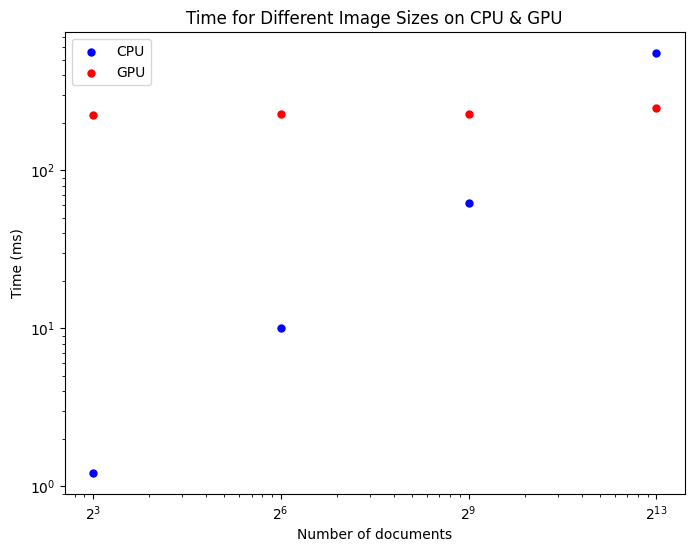

In [9]:
import math
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(cpu_df['n_docs'], cpu_df['mean_execution_time'], label='CPU', marker='.', s=100, c='blue')

ax.scatter(gpu_df['n_docs'], gpu_df['mean_execution_time'], label="GPU", marker='.', s=100, c='red')

ax.set_title('Time for Different Image Sizes on CPU & GPU')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Number of documents')
ax.set_xscale("log")
ax.set_yscale("log")
plt.xticks(cpu_df['n_docs'], labels=[f"$2^{{{int(math.log(n_inp_element, 2))}}}$" for n_inp_element in cpu_df['n_docs'].values])
ax.legend()

plt.show()